In [1]:
import os
import pandas as pd
os.chdir("C:\\Users\\Thispc\\Downloads")

In [2]:
import re
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
f = open('covid.txt','r')
lines=f.readlines()
texts=lines[0]

In [4]:
with open ("cv20.csv", "r", encoding="utf-8") as myfile:
    text1=myfile.readlines()

In [5]:
def get_entities(sent):
    ent1 = ""
    ent2 = ""
    prv_tok_dep = ""  
    prv_tok_text = "" 
    prefix = ""
    modifier = ""
    for tok in nlp(sent):
        if tok.dep_ != "punct":
            if tok.dep_ == "compound":
                prefix = tok.text
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " " + tok.text
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " " + tok.text
            if tok.dep_.find("subj") == True:
                ent1 = modifier + " " + prefix + " " + tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""
            if tok.dep_.find("obj") == True:
                ent2 = modifier + " " + prefix + " " + tok.text
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text
    return [ent1.strip(), ent2.strip()]

In [6]:
text1

[',Unnamed: 0,abstract\n',
 '0,0,"OBJECTIVE: This retrospective chart review describes the epidemiology and clinical features of 40 patients with culture-proven Mycoplasma pneumoniae infections at King Abdulaziz University Hospital, Jeddah, Saudi Arabia. METHODS: Patients with positive M. pneumoniae cultures from respiratory specimens from January 1997 through December 1998 were identified through the Microbiology records. Charts of patients were reviewed. RESULTS: 40 patients were identified, 33 (82.5%) of whom required admission. Most infections (92.5%) were community-acquired. The infection affected all age groups but was most common in infants (32.5%) and pre-school children (22.5%). It occurred year-round but was most common in the fall (35%) and spring (30%). More than three-quarters of patients (77.5%) had comorbidities. Twenty-four isolates (60%) were associated with pneumonia, 14 (35%) with upper respiratory tract infections, and 2 (5%) with bronchiolitis. Cough (82.5%), fever

In [7]:
get_entities(texts)

['preschool mortality rate', 'comorbidities']

In [8]:
entity_pairs = []

for i in tqdm(text1):
    entity_pairs.append(get_entities(i))

100%|████████████████████████████████████████████████████████████████████████████| 10001/10001 [26:05<00:00,  6.39it/s]


In [9]:
entity_pairs[10:20]

[['two Winter It', 'public health surveillance'],
 ['mammalian core element', 'common  yeast'],
 ['cellular MHV RNA findings', 'dependent RNA synthesis'],
 ['interacting UBA application', 'important  that'],
 ['Further centrosome studies', 'viral centrosome function'],
 ['', ''],
 ['diagnostic  which', 'viral  AIDS'],
 ['critically  isolation', 'primary  lungs'],
 ['well ring vaccination', 'public  awareness'],
 ['DNA repair', 'damaging excision repair O(2']]

In [10]:
def get_relation(sent):

    doc = nlp(sent)
    matcher = Matcher(nlp.vocab)
    pattern = [{'DEP':'ROOT'},
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1", [pattern]) 

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]] 

    return(span.text)

In [11]:
get_relation(texts)

'CONCLUSION'

In [12]:
relations = [get_relation(i) for i in tqdm(text1)]

100%|████████████████████████████████████████████████████████████████████████████| 10001/10001 [25:38<00:00,  6.50it/s]


In [13]:
pd.Series(relations).value_counts()[:50]

"                     7328
see                     24
is available            20
CONCLUSIONS             19
suggest                 19
is                      18
CONCLUSION              15
indicate                13
REGISTRATION            12
are                      8
DOI                      8
discussed                6
indicated                6
discuss                  6
be                       5
provide                  5
suggested                5
needed                   4
Inc.                     4
shown                    3
showed                   3
Transplantation          3
found                    3
provides                 3
Registered               3
play                     2
obtained                 2
demonstrate              2
NUMBER                   2
reports                  2
conclude                 2
report                   2
engineered               2
explain                  2
used                     2
reviews                  2
present                  2
I

In [14]:
source = [i[0] for i in entity_pairs]
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df

,source,target,edge
0,,,Unnamed
1,preschool mortality rate,comorbidities,""""
2,Instead it,inflammatory lung,""""
3,deficient lung accumulation,oligomerized human lung diseases,""""
4,inflammatory lung review,lung disease,""""
...,...,...,...
9996,diseases,routinely resource allocation,""""
9997,respiratory review,professional athletes,""""
9998,viral on‐demand studies,prophylactic haemophilia A.,confirm
9999,de las,vías nerviosas,""""


In [18]:
kg_df['edge'].value_counts()

"               7328
see               24
is available      20
CONCLUSIONS       19
suggest           19
                ... 
6384,6384          1
6385,6385          1
6387,6387          1
6388,6388          1
confirm            1
Name: edge, Length: 2450, dtype: int64

In [15]:
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

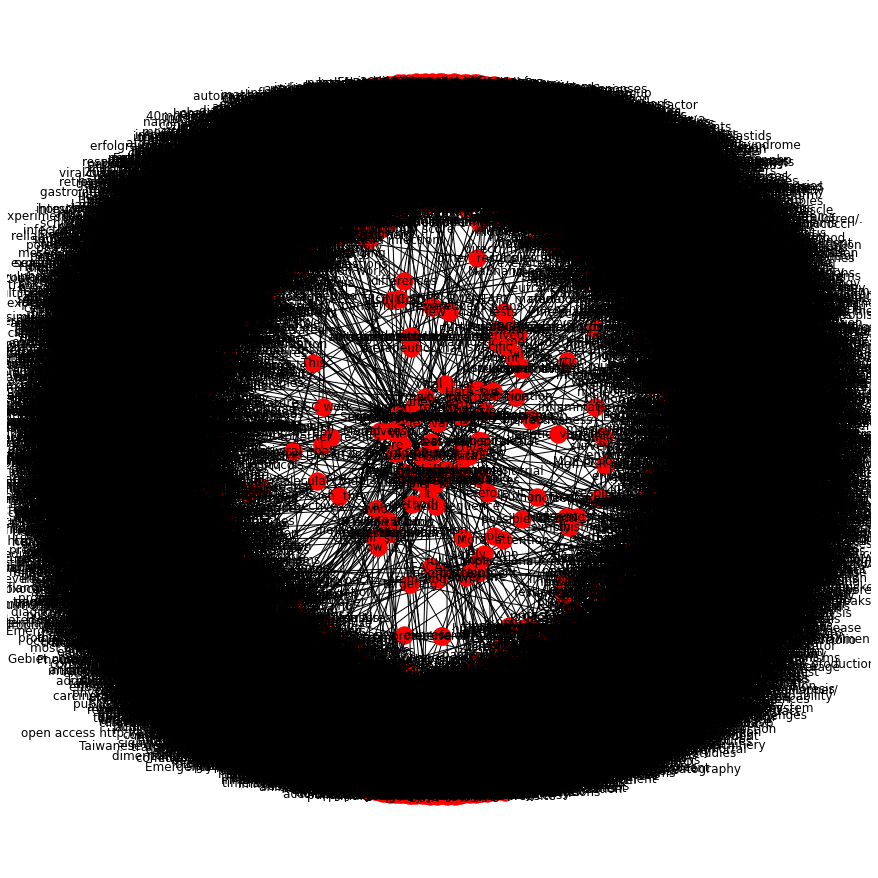

In [16]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='red', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

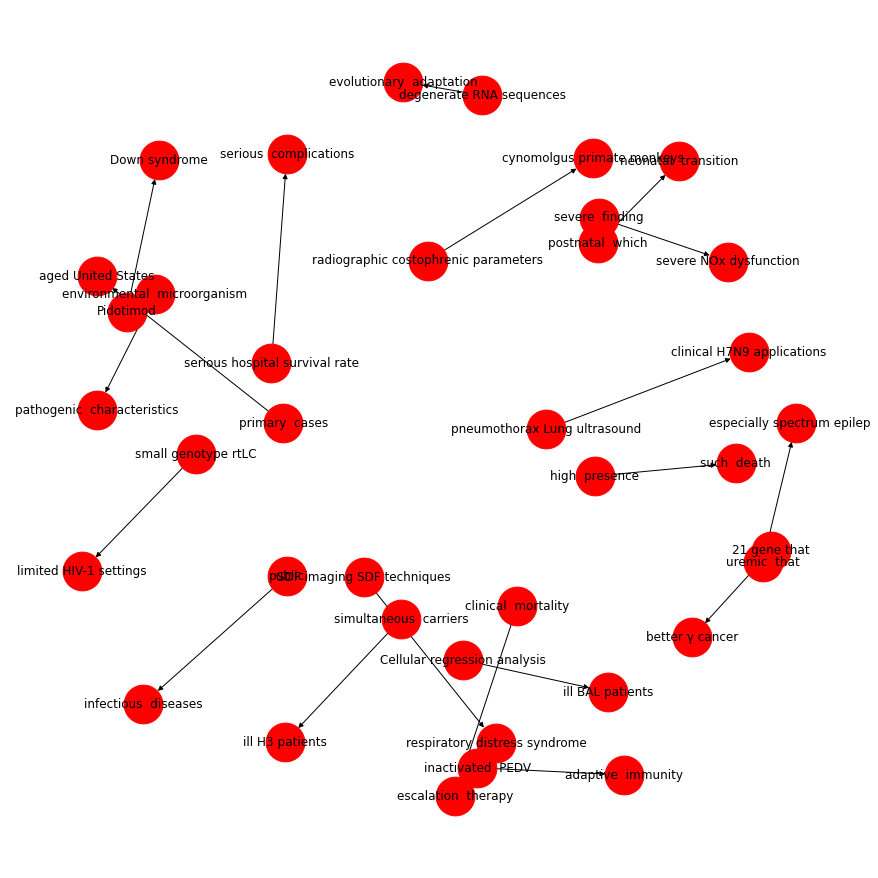

In [17]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="CONCLUSIONS"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

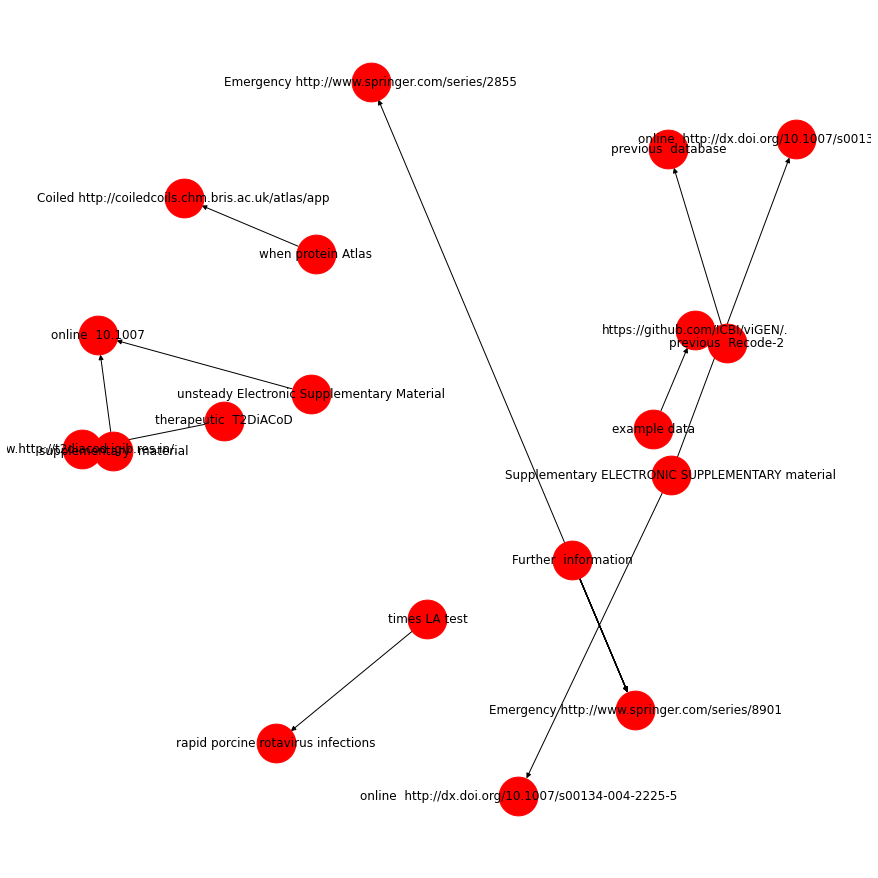

In [19]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="is available"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

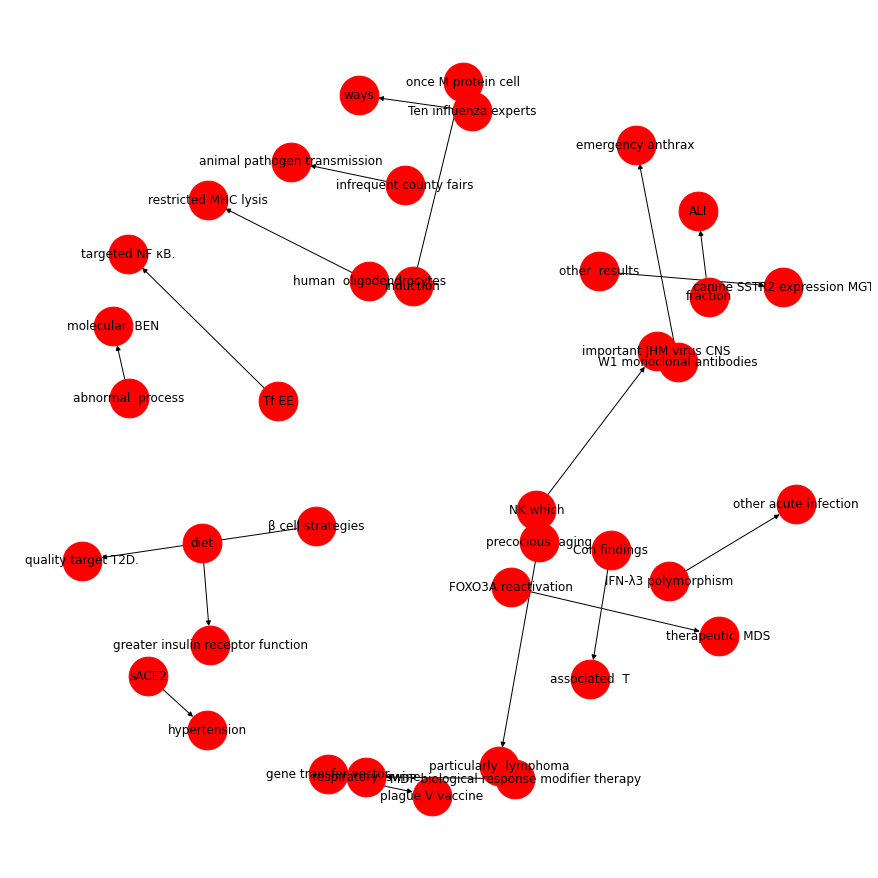

In [20]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="suggest"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()